In [1]:
# Learn to draw gaussian

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision.ops import nms, box_convert

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install opencv-python-headless

In [3]:
def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  return min(r1, r2, r3)

def gaussian_radius2(det_size, min_overlap):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 - sq1) / (2 * a1)

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 - sq2) / (2 * a2)

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / (2 * a3)
    return min(r1, r2, r3)
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  # print(gaussian.shape)
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap

32 32
97 95
32 32
(2, 64, 64)
hm.shape: (2, 64, 64), regr.shape: (2, 64, 64), wh_regr.shape: (2, 64, 64), w_h_.shape: (128, 2),inds.shape: (128,), ind_masks.shape: (128,)
[1950 2080 1755    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
tensor([[[30.0000, 30.0000],
         [32.5000, 33.5000],
         [27.0000, 27.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
    

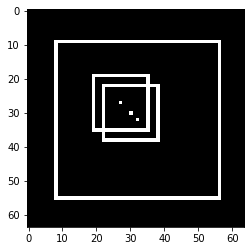

In [40]:
# hm = np.zeros((2,128,128))
input_size = 128
MODEL_SCALE=2
# cs = np.array([[60,60,32,32],[64,64,96,96],[54,54,32,32]])
boxes = np.array([[44,44,76,76],
                  [16,18,113,113],
                  [38,38,70,70]])

classes = np.array([0,1,0])
# c = np.array([64,64,100,100])
# print(cs.shape)

# hm_vis = hm.copy()

def encode_hm_regr_and_wh_regr(boxes, classes,N_CLASSES=None, input_size=None,MODEL_SCALE=None):
    '''
    '''
    max_objs=128
    fmap_dim = input_size//MODEL_SCALE
    hm = np.zeros((N_CLASSES,fmap_dim,fmap_dim),dtype=np.float32)
    regr = np.zeros((2, fmap_dim, fmap_dim), dtype=np.float32)
    wh_regr = np.zeros((2, fmap_dim, fmap_dim), dtype=np.float32)
    inds = np.zeros((max_objs,), dtype=np.int64)
    ind_masks = np.zeros((max_objs,), dtype=np.uint8)
    w_h_ = np.zeros((max_objs, 2), dtype=np.float32)  # width and height
    for ind,(c,cl) in enumerate(zip(boxes,classes)):
        x,y,x2,y2 = c
        w = int(x2-x)
        h = int(y2-y)
        print(w,h)
        centers = [(x+x2)/2.,(y+y2)/2.]
        # print("centers: ",centers)
        c_s = np.array([i/MODEL_SCALE for i in centers])
        # print("c_s: ",c_s)
        centers_int = c_s.copy().astype(np.int32)
        # print("centers_int: ",centers_int)
        # centers_sc = np.array([int(i)//MODEL_SCALE for i in c_s],dtype=np.float32)
        # print("centers-centers_int: ",centers-centers_int)
        radius = gaussian_radius2((math.ceil(h//MODEL_SCALE), math.ceil(w//MODEL_SCALE)),min_overlap=1.0)
        radius = max(0, int(radius))
        draw_umich_gaussian(hm[cl], centers_int, 
                                radius)
        draw_dense_reg(wh_regr,hm[cl],c_s,np.array([w,h],dtype=np.float32),radius)
        draw_dense_reg(regr,hm[cl],c_s,centers-centers_int,radius)
        w_h_[ind] = 1. * w, 1. * h
        inds[ind] = centers_int[1] * fmap_dim + centers_int[0]
        ind_masks[ind] = 1
    
    return hm, regr, wh_regr, w_h_,inds, ind_masks

def visualize_gt_on_output(boxes, classes,hm,MODEL_SCALE=None):
    '''
    '''
    hm_vis = hm.sum(0)
    for b,cl in zip(boxes, classes):
        x,y,x2,y2 = b
        w = int(x2-x)
        h = int(y2-y)
        centers = [(x+x2)/2,(y+y2)/2]
        c_s = np.array([int(i//MODEL_SCALE) for i in centers]).astype(np.int32)
        print(c_s[0]-w//MODEL_SCALE//2)
        cv2.rectangle(hm_vis,(c_s[0]-w//MODEL_SCALE//2,c_s[1]-h//MODEL_SCALE//2),(c_s[0]+w//MODEL_SCALE//2,c_s[1]+h//MODEL_SCALE//2),1)
    return hm_vis

hm, regr, wh_regr, w_h_,inds, ind_masks= encode_hm_regr_and_wh_regr(boxes, classes,N_CLASSES=2, input_size=128,MODEL_SCALE=2)
print(hm.shape)
print("hm.shape: {}, regr.shape: {}, wh_regr.shape: {}, w_h_.shape: {},inds.shape: {}, ind_masks.shape: {}".format(hm.shape, 
                                                                                               regr.shape, 
                                                                                               wh_regr.shape, 
                                                                                               w_h_.shape,
                                                                                               inds.shape, 
                                                                                               ind_masks.shape))
# print(inds)
# print(_tranpose_and_gather_feature(torch.from_numpy(regr).unsqueeze(0),torch.from_numpy(inds).unsqueeze(0)))
plt.imshow(visualize_gt_on_output(boxes, classes,hm,MODEL_SCALE=2),cmap='gray')

# plt.imshow(hm[0]*255,cmap='gray')
# plt.show()
# plt.imshow(hm[1]*255,cmap='gray')
# plt.show()
# plt.imshow(hm_vis[0]+hm_vis[1],cmap='gray')
# plt.show()

# plt.imshow(wh_regr.transpose(1,2,0)[:,:,0])
# plt.show()

In [21]:
# hm_vis_2 = hm.copy()
# boxes, scores = pred2box(torch.from_numpy(hm),torch.from_numpy(wh_regr),threshold=0.99, scale=1,input_size=128)
# for ind,(b,s) in enumerate(zip(boxes, scores)):
#     cx,cy,w,h = [int(i) for i in b.numpy()]
#     print(cx,cy,w,h)
#     cv2.rectangle(hm_vis_2, (cx-w//2,cy-h//2),(cx+w//2,cy+h//2),1)
# plt.imshow(hm_vis_2)
    

In [29]:
def nonempty(boxes,threshold: float = 0.0) -> torch.Tensor:
        """
        Find boxes that are non-empty.
        A box is considered empty, if either of its side is no larger than threshold.
        Returns:
            Tensor:
                a binary vector which represents whether each box is empty
                (False) or non-empty (True).
        """
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        keep = (widths > threshold) & (heights > threshold)
        return keep

def _gather_feature(feat, ind, mask=None):
  dim = feat.size(2)
  ind = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
  feat = feat.gather(1, ind)
  if mask is not None:
    mask = mask.unsqueeze(2).expand_as(feat)
    feat = feat[mask]
    feat = feat.view(-1, dim)
  return feat


def _tranpose_and_gather_feature(feat, ind):
  feat = feat.permute(0, 2, 3, 1).contiguous()
  feat = feat.view(feat.size(0), -1, feat.size(3))
  feat = _gather_feature(feat, ind)
  return feat

def _topk(scores, K=40):
  batch, cat, height, width = scores.size()

  topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

  topk_inds = topk_inds % (height * width)
  topk_ys = (topk_inds / width).int().float()
  topk_xs = (topk_inds % width).int().float()

  topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
  topk_clses = (topk_ind / K).int()
  topk_inds = _gather_feature(topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
  topk_ys = _gather_feature(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
  topk_xs = _gather_feature(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

  return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

def decode_predictions(hm,regr,wh_regr,MODEL_SCALE=None,K=100):
    '''
    hm: BxCxHxW
    regr: Bx2xHxW
    wh_regr: Bx2xHxW
    '''
    
    batch,cat, height, width = hm.shape

    scores, inds, clses, ys, xs = _topk(hm, K=K)

    regs = _tranpose_and_gather_feature(regr, inds)
    regs = regs.view(batch, K, 2)
    # print(regs.shape)
    # print(xs.view(batch, K, 1))
    # print(xs.view(batch, K, 1)*MODEL_SCALE)
    # print(xs.view(batch, K, 1)*MODEL_SCALE+regs[:, :, 0:1])
    xs = xs.view(batch, K, 1)+regs[:, :, 0:1]
    ys = ys.view(batch, K, 1)+regs[:, :, 1:2]
    # print(xs)


    w_h_ = _tranpose_and_gather_feature(wh_regr, inds)
    w_h_ = w_h_.view(batch, K, 2)
    # print(ys)
    # print(w_h_ /2)
    clses = clses.view(batch, K, 1).float().squeeze(0).squeeze(-1)
    scores = scores.view(batch, K, 1).squeeze(0).squeeze(-1).type(torch.float32)
    boxes = torch.cat([xs - w_h_[..., 0:1] / 2,
                      ys - w_h_[..., 1:2] / 2,
                      xs + w_h_[..., 0:1] / 2,
                      ys + w_h_[..., 1:2] / 2], dim=2).squeeze(0)

    keep = nonempty(boxes)
    boxes=boxes[keep]
    scores=scores[keep]
    clses = clses[keep]
    # idx = nms(boxes, scores, 0.5)
    # boxes = boxes[idx]
    # scores = scores[idx]
    # clses = clses[idx]
    
    return boxes,scores,clses

hm_b = torch.from_numpy(hm).unsqueeze(0)
regr_b = torch.from_numpy(regr).unsqueeze(0)
wh_regr_b = torch.from_numpy(wh_regr).unsqueeze(0)
boxes,scores,clses = decode_predictions(hm_b,regr_b,wh_regr_b,MODEL_SCALE=MODEL_SCALE,K=100)
'''
boxes = np.array([[44,44,76,76],
                  [15,17,113,113],
                  [38,38,70,70]])
'''
print(boxes,scores,clses)
# if want coco representation: 
# box_cxcywh = box_convert(boxes, in_fmt="xyxy", out_fmt="cxcywh")

tensor([[ 16.,  18., 113., 113.],
        [ 38.,  38.,  70.,  70.],
        [ 44.,  44.,  76.,  76.]]) tensor([1., 1., 1.]) tensor([1., 0., 0.])


In [25]:



# def process_centernet_output(
#     predicted_heatmap,  # logits
#     predicted_regression,
#     gt_boxes,
#     gt_labels,
#     confidence_threshold=0.5,
#     iou_threshold=0.5,
# ):
#     """Generate bbox and classes from CenterNet model outputs.
#     Args:
#         predicted_heatmap (torch.Tensor): predicted center heatmap logits,
#             expected shapes [batch, height, width, num classes].
#         predicted_regression (torch.Tensor): predicted HW regression,
#             expected shapes [batch, height, width, 2].
#         gt_boxes (List[torch.Tensor]): list with sample bounding boxes.
#         gt_labels (List[torch.Tensor]): list with sample bounding box labels.
#         confidence_threshold (float): confidence threshold,
#             proposals with lover values than threshold will be ignored.
#             Default is ``0.5``.
#         iou_threshold (float): IoU threshold to use in NMS.
#             Default is ``0.5``.
#     Yields:
#         predicted sample (np.ndarray) and ground truth sample (np.ndarray)
#     """
#     batch_size = predicted_heatmap.size(0)

#     hm = predicted_heatmap.sigmoid()
#     pooled = F.max_pool2d(hm, kernel_size=(3, 3), stride=1, padding=1)
#     hm *= torch.logical_and(
#         hm >= confidence_threshold, pooled >= confidence_threshold
#     ).float()

#     hm_numpy = hm.detach().cpu().numpy()
#     reg_numpy = predicted_regression.detach().cpu().numpy()

#     for i in range(batch_size):
#         sample_boxes = []
#         sample_classes = []
#         sample_scores = []
#         for cls_idx in range(hm_numpy.shape[1]):
#             # build predictions
#             cls_boxes, cls_scores = pred2box(
#                 hm_numpy[i, cls_idx], reg_numpy[i], threshold=0, scale=4, input_size=512
#             )

#             # skip empty label predictions
#             if cls_scores.shape[0] == 0:
#                 continue

#             cls_boxes = cls_boxes / 512.0

#             cls_boxes, cls_classes, cls_scores = nms_filter(
#                 cls_boxes,
#                 np.full(len(cls_scores), cls_idx),
#                 cls_scores,
#                 iou_threshold=iou_threshold,
#             )
#             sample_boxes.append(cls_boxes)
#             sample_classes.append(cls_classes)
#             sample_scores.append(cls_scores)
#         # skip empty predictions
#         if len(sample_boxes) == 0:
#             continue

#         sample_boxes = np.concatenate(sample_boxes, 0)
#         sample_classes = np.concatenate(sample_classes, 0)
#         sample_scores = np.concatenate(sample_scores, 0)

#         pred_sample = np.concatenate(
#             [sample_boxes, sample_classes[:, None], sample_scores[:, None]], -1
#         )
#         pred_sample = pred_sample.astype(np.float32)

#         sample_gt_bboxes = gt_boxes[i].detach().cpu()
#         sample_gt_classes = gt_labels[i].detach().cpu()
#         gt_sample = np.zeros((sample_gt_classes.shape[0], 7), dtype=np.float32)
#         gt_sample[:, :4] = sample_gt_bboxes
#         gt_sample[:, 4] = sample_gt_classes

#         yield pred_sample, gt_sample
# class CenterNetDataset(Dataset):
#     def __init__(self, coco_json_path, images_dir=None, transforms=None, down_ratio=4):
#         self.file = coco_json_path
#         self.img_dir = images_dir
#         self.transforms = transforms
#         self.down_ratio = down_ratio

#         self.images, self.categories = load_coco_json(coco_json_path)
#         self.images_list = sorted(self.images.keys())

#         self.class_to_cid = {
#             cls_idx: cat_id
#             for cls_idx, cat_id in enumerate(sorted(self.categories.keys()))
#         }
#         self.cid_to_class = {v: k for k, v in self.class_to_cid.items()}
#         self.num_classes = len(self.class_to_cid)
#         self.class_labels = [
#             self.categories[self.class_to_cid[cls_idx]]
#             for cls_idx in range(len(self.class_to_cid))
#         ]

#     def __len__(self):
#         return len(self.images_list)

#     def __getitem__(self, index):
#         img_id = self.images_list[index]
#         img_record = self.images[img_id]

#         path = img_record["file_name"]
#         if self.img_dir is not None:
#             path = os.path.join(self.img_dir, path)
#         image = read_image(path)
#         original_size = [image.shape[0], image.shape[1]]  # height, width

#         boxes = []  # each element is a tuple of (x1, y1, x2, y2, "class")
#         for annotation in img_record["annotations"]:
#             pixel_xywh = annotation["bbox"]
#             # skip bounding boxes with 0 height or 0 width
#             if pixel_xywh[2] == 0 or pixel_xywh[3] == 0:
#                 continue
#             xyxy = pixels_to_absolute(
#                 pixel_xywh, width=img_record["width"], height=img_record["height"]
#             )
#             xyxy = clip(xyxy, 0.0, 1.0)
#             bbox_class = str(self.cid_to_class[annotation["category_id"]])
#             boxes.append(xyxy + [str(bbox_class)])

#         if self.transforms is not None:
#             transformed = self.transforms(image=image, bboxes=boxes)
#             image, boxes = transformed["image"], transformed["bboxes"]
#         else:
#             image = torch.from_numpy((image / 255.0).astype(np.float32)).permute(2, 0, 1)

#         labels = np.array([int(items[4]) for items in boxes])
#         boxes = np.array([items[:4] for items in boxes], dtype=np.float32)
#         # boxes = change_box_order(boxes, "xyxy2xywh")  # (x1, y1, x2, y2) -> (cx, cy, w, h)

#         heatmap_height = image.shape[1] // self.down_ratio
#         heatmap_width = image.shape[2] // self.down_ratio
#         # draw class centers
#         heatmap = np.zeros(
#             (self.num_classes, heatmap_height, heatmap_width), dtype=np.float32
#         )
#         for (x1, y1, x2, y2), cls_channel in zip(boxes, labels):
#             w, h = abs(x2 - x1), abs(y2 - y1)
#             xc, yc = x1 + w // 2, y1 + h // 2
#             scaled_xc = int(xc * heatmap_width)
#             scaled_yc = int(yc * heatmap_height)
#             draw_msra_gaussian(
#                 heatmap, cls_channel, (scaled_xc, scaled_yc), sigma=np.clip(w * h, 2, 4)
#             )
#         # draw regression squares
#         wh_regr = np.zeros((2, heatmap_height, heatmap_width), dtype=np.float32)
#         regrs = boxes[:, 2:] - boxes[:, :2]  # width, height
#         for r, (x1, y1, x2, y2) in zip(regrs, boxes):
#             w, h = abs(x2 - x1), abs(y2 - y1)
#             xc, yc = x1 + w // 2, y1 + h // 2
#             scaled_xc = int(xc * heatmap_width)
#             scaled_yc = int(yc * heatmap_height)
#             for i in range(-2, 2 + 1):
#                 for j in range(-2, 2 + 1):
#                     try:
#                         a = max(scaled_xc + i, 0)
#                         b = min(scaled_yc + j, heatmap_height)
#                         wh_regr[:, a, b] = r
#                     except:  # noqa: E722
#                         pass
#         wh_regr[0] = wh_regr[0].T
#         wh_regr[1] = wh_regr[1].T

#         return {
#             "image": image,
#             "original_size": original_size,
#             "size": [image.size(1), image.size(2)],
#             "heatmap": torch.from_numpy(heatmap),
#             "wh_regr": torch.from_numpy(wh_regr),
#             "bboxes": boxes,
#             "labels": labels,
#         }

#     @staticmethod
#     def collate_fn(batch):
#         keys = list(batch[0].keys())
#         packed_batch = {k: [] for k in keys}
#         for element in batch:
#             for k in keys:
#                 packed_batch[k].append(element[k])
#         for k in ("image", "heatmap", "wh_regr"):
#             packed_batch[k] = torch.stack(packed_batch[k], 0)
#         return packed_batch
